## Space Invaders With DDQN
### Dueling Deep Q-Networks

## Step 0: For run in Google Colab

1- For using Space Invaders in Colab we need to download ROMS and Import the environment

In [ ]:
# 1- Run this cell to Import the environment
! wget http://www.atarimania.com/roms/Roms.rar
! mkdir /content/ROM/
! unrar e /content/Roms.rar /content/ROM/
! python -m atari_py.import_roms /content/ROM/

2- To displaye the Agent & Environment we use env.render() but not work in colab, for runing env.render() use the below cells

In [ ]:
# 2- Dowload and install requirements
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [ ]:
# 2- Dowload and install requirements
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))

In [ ]:
# Next, we define the functions used to show the video by adding it to the CoLab 
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""


def show_video():
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")


def wrap_env(env):
    env = Monitor(env, './video', force=True)
    return env


## Step 1: Import the libraries

In [1]:
import time
import gym
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math
%matplotlib inline

In [2]:
from ddqn_agent import DDQNAgent
from ddqn_cnn import DDQNCnn
from stack_frame import preprocess_frame, stack_frame


## Step 2: Create our environment

Initialize the environment in the code cell below.

**Note**: If you to run this notebook in your PC

    1. pip uninstall gym 
    2. pip install gym 
    3. env = gym.make('SpaceInvaders-v4', render_mode='human')
    render_mode='human' is for show the graphical environment output

In [3]:
# env = wrap_env(gym.make('SpaceInvaders-v0')) # for google colab # Comment this when use PC
env = gym.make('SpaceInvaders-v4', render_mode="human") # for run in PC
env.seed(0)

c:\Users\Amin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
c:\Users\Amin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


(2968811710, 3677149159)

In [9]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cpu


## Step 3: Viewing our Enviroment

The size of frame is:  (210, 160, 3)
No. of Actions:  6


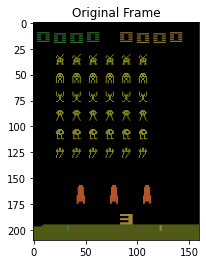

In [4]:
print("The size of frame is: ", env.observation_space.shape)
print("No. of Actions: ", env.action_space.n)
env.reset()
plt.figure()
plt.imshow(env.reset())
plt.title('Original Frame')
plt.show()

### Execute the code cell below to play Pong with a random policy.

c:\Users\Amin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\core.py:51: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
c:\Users\Amin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:297: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
c:\Users\Amin\AppData\Local\Programs\Python\Python310\lib\site-packages\gym\utils\passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


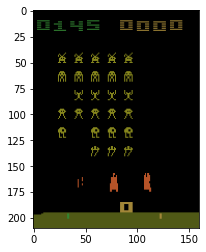

Your Score at end of game is:  145.0


In [5]:
# env = wrap_env(gym.make('SpaceInvaders-v0')) # unComment this when use Google Colab
def random_play():
    score = 0
    env.reset()
    while True:
        # env.render() # it is OK for GOOGLE COLAB # Comment this when use PC
        plt.imshow(env.render('rgb_array')) # for using in PC
        action = env.action_space.sample()
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            env.close()
            plt.show() # show the final output in PC
            show_video() # Comment this when use PC
            print("Your Score at end of game is: ", score)
            break
random_play()

## Step 4:Preprocessing Frame

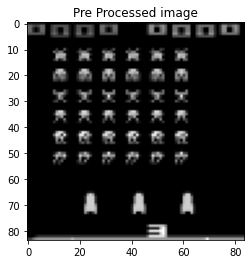

In [6]:
env.reset()
plt.figure()
plt.imshow(preprocess_frame(env.reset(), (8, -12, -12, 4), 84), cmap="gray")
plt.title('Pre Processed image')
plt.show()

## Step 5: Stacking Frame

In [7]:
def stack_frames(frames, state, is_new=False):
    frame = preprocess_frame(state, (8, -12, -12, 4), 84)
    frames = stack_frame(frames, frame, is_new)

    return frames

## Step 6: Creating our Agent

In [10]:
INPUT_SHAPE = (4, 84, 84)
ACTION_SIZE = env.action_space.n
SEED = 0
GAMMA = 0.99           # discount factor
BUFFER_SIZE = 100000   # replay buffer size
BATCH_SIZE = 32        # Update batch size
LR = 0.0001            # learning rate 
TAU = .1               # for soft update of target parameters
UPDATE_EVERY = 100     # how often to update the network
UPDATE_TARGET = 10000  # After which thershold replay to be started 
EPS_START = 0.99       # starting value of epsilon
EPS_END = 0.01         # Ending value of epsilon
EPS_DECAY = 100        # Rate by which epsilon to be decayed

agent = DDQNAgent(INPUT_SHAPE, ACTION_SIZE, SEED, device, BUFFER_SIZE, BATCH_SIZE, GAMMA, LR, TAU, UPDATE_EVERY, UPDATE_TARGET, DDQNCnn)

## Step 7: Watching untrained agent play

In [11]:
# watch an untrained agent
state = stack_frames(None, env.reset(), True) 
for j in range(200):
    # env.render() # for google colab it is ok # Comment this when use PC
    env.render('rgb_array') # fur when using PC
    action = agent.act(state, .9)
    next_state, reward, done, _ = env.step(action)
    state = stack_frames(state, next_state, False)
    if done:
        break 
env.close()
# show_video() # unComment this when useing colab

## Step 8: Loading Agent
Uncomment line to load a pretrained agent

In [12]:
start_epoch = 0
scores = []
scores_window = deque(maxlen=20)

## Step 9: Train the Agent with DQN

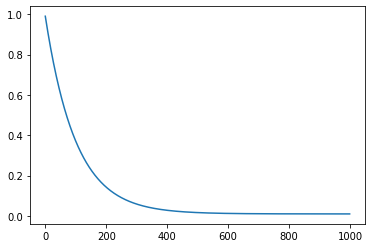

In [13]:
epsilon_by_epsiode = lambda frame_idx: EPS_END + (EPS_START - EPS_END) * math.exp(-1. * frame_idx /EPS_DECAY)

plt.plot([epsilon_by_epsiode(i) for i in range(1000)])

In [14]:
def train(n_episodes=1000):
    """
    Params
    ======
        n_episodes (int): maximum number of training episodes
    """
    for i_episode in range(start_epoch + 1, n_episodes+1):
        state = stack_frames(None, env.reset(), True)
        score = 0
        eps = epsilon_by_epsiode(i_episode)
        while True:
            action = agent.act(state, eps)
            next_state, reward, done, info = env.step(action)
            score += reward
            next_state = stack_frames(state, next_state, False)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            if done:
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        
        clear_output(True)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        plt.plot(np.arange(len(scores)), scores)
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(scores_window), eps), end="")
    
    return scores

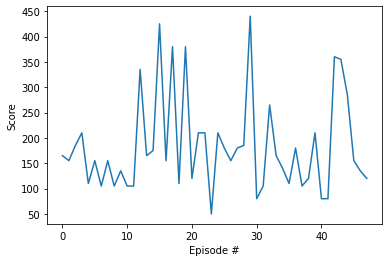

Episode 48	Average Score: 183.75	Epsilon: 0.62

KeyboardInterrupt: 

In [15]:
scores = train(1000)

585 => 288

600 => 310

650 => 36min

1000 => 1 h => 300



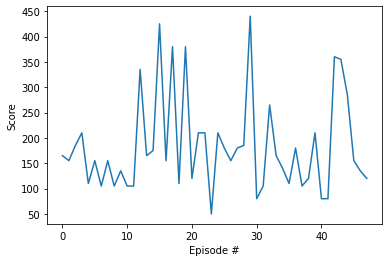

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Step 10: Watch a Smart Agent!

In [19]:
score = 0
state = stack_frames(None, env.reset(), True)
while True:
    env.render('rgb_array')
    action = agent.act(state, .01)
    next_state, reward, done, _ = env.step(action)
    score += reward
    state = stack_frames(state, next_state, False)
    if done:
        print("You Final score is:", score)
        break 
env.close()
show_video()

: 

: 